# Introducing Convolutional Neural Networks

#### The following topics will be covered in this chapter:

* The problem with traditional deep neural networks

* Building blocks of a CNN

* Implementing a CNN

* Classifying images using deep CNNs

* Implementing data augmentation

* Visualizing the outcome of feature learning

* Building a CNN for classifying real-world images

# The problem with traditional deep neural networks

In [1]:
from torchvision import datasets
import torch
data_folder = 'Dataset' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:25<00:00, 1018384.77it/s]


Extracting Dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to Dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 308569.21it/s]


Extracting Dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1039096.40it/s]


Extracting Dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4222189.48it/s]


Extracting Dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Dataset/FashionMNIST/raw



In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [7]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


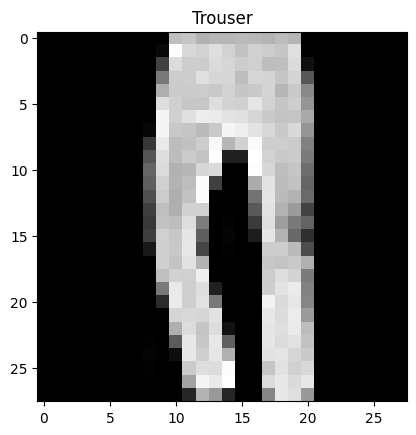

In [11]:
# 1. Fetch a random image from the available training images
ix = 24300
plt.imshow(tr_images[ix],cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])
plt.show()

In [13]:
# 2. Pass the image through the trained mode
## Preprocess the image so it goes through the same pre-processing steps we performed while building the model
img = tr_images[ix]/255
img = img.view(28*28)
img = img.to(device=device)

## Extract the probabilities associated with the various classes 
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([1.2273968e-03, 9.9873716e-01, 8.0490327e-07, 1.9276174e-05,
       8.3644034e-07, 5.7215500e-12, 1.4509570e-05, 9.1665482e-16,
       3.8547906e-08, 2.1145303e-12], dtype=float32)

###### we can see that the highest probability is for the 1st index, which is of the Trouser class.

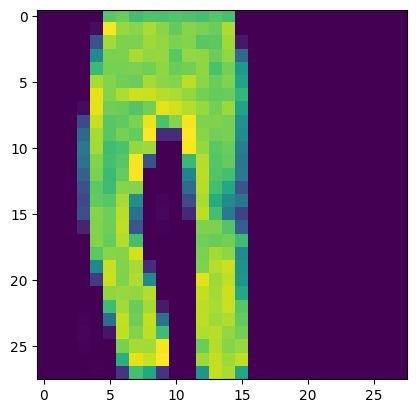

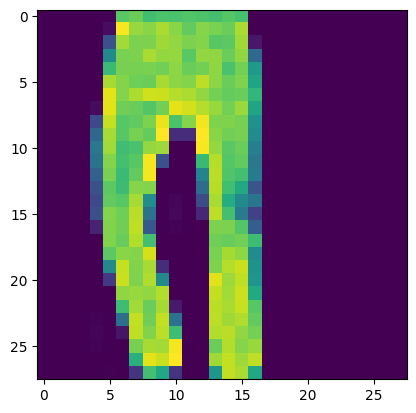

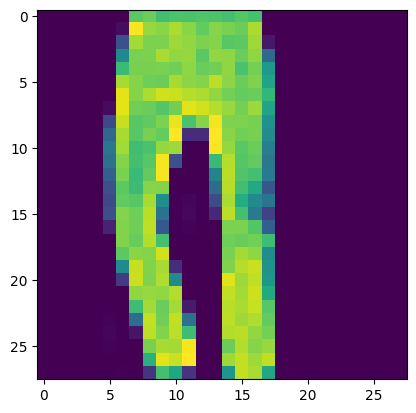

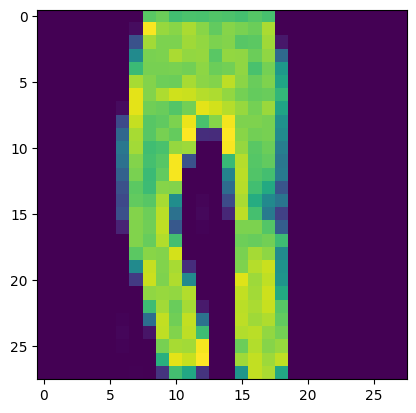

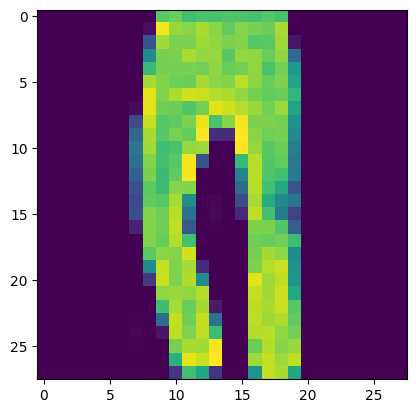

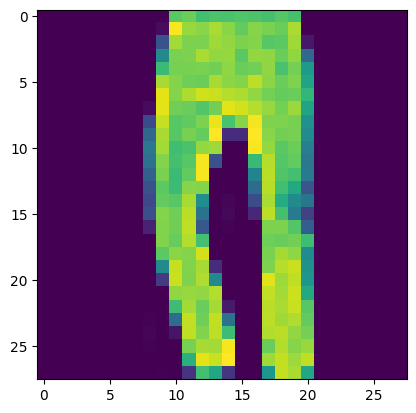

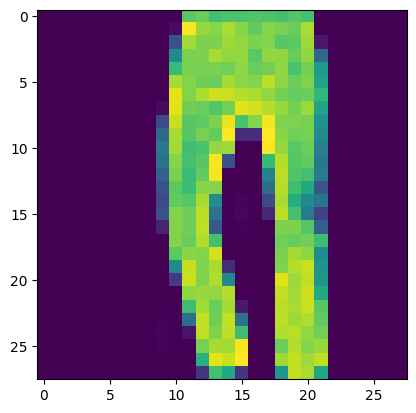

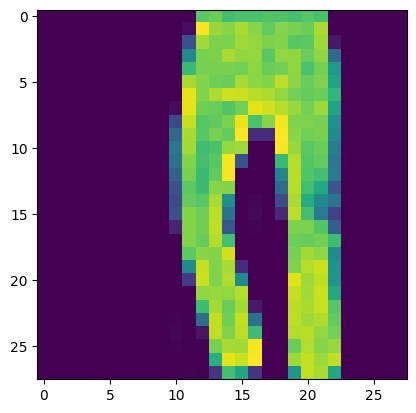

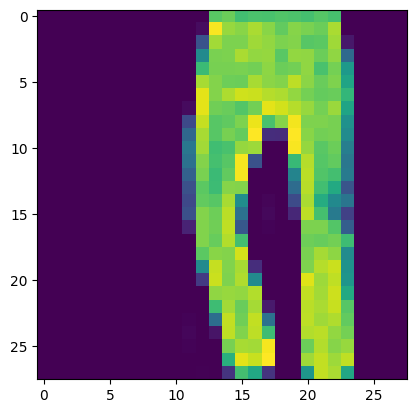

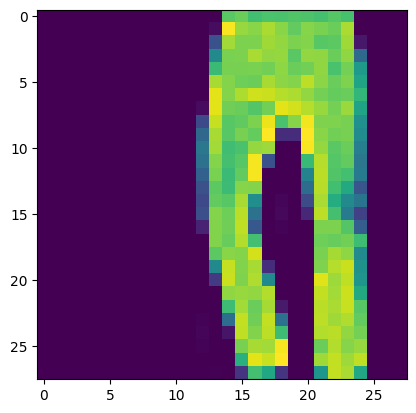

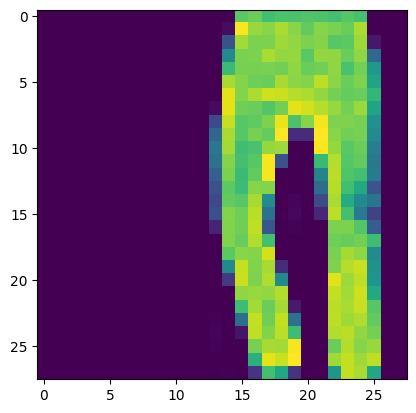

In [15]:
# 3. Translate (roll/slide) the image multiple times (one pixel at a time) from a translation of 5 pixels to the left to 5 pixels to the right and store the predictions in a list.
## Create a list that stores predictions
preds = []

## Create a loop that translates (rolls) an image from -5 pixels (5 pixels to the left) to +5 pixels (5 pixels to the right) of the original position (which is at the center of the image)
for px in range(-5,6):
  # Pre-process the image
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))

  # Roll the image by a value equal to px within the for loop
  img2 = np.roll(img, px, axis=1) # we specified axis=1 since we want the image pixels to be moving horizontally 
  plt.imshow(img2)
  plt.show()
  
  # Store the rolled image as a tensor object and register it to device:
  img3 = torch.Tensor(img2).view(28*28).to(device)
  
  # Pass img3 through the trained model to predict the class of the translated (rolled) image and append it to the list that is storing predictions for various translations
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

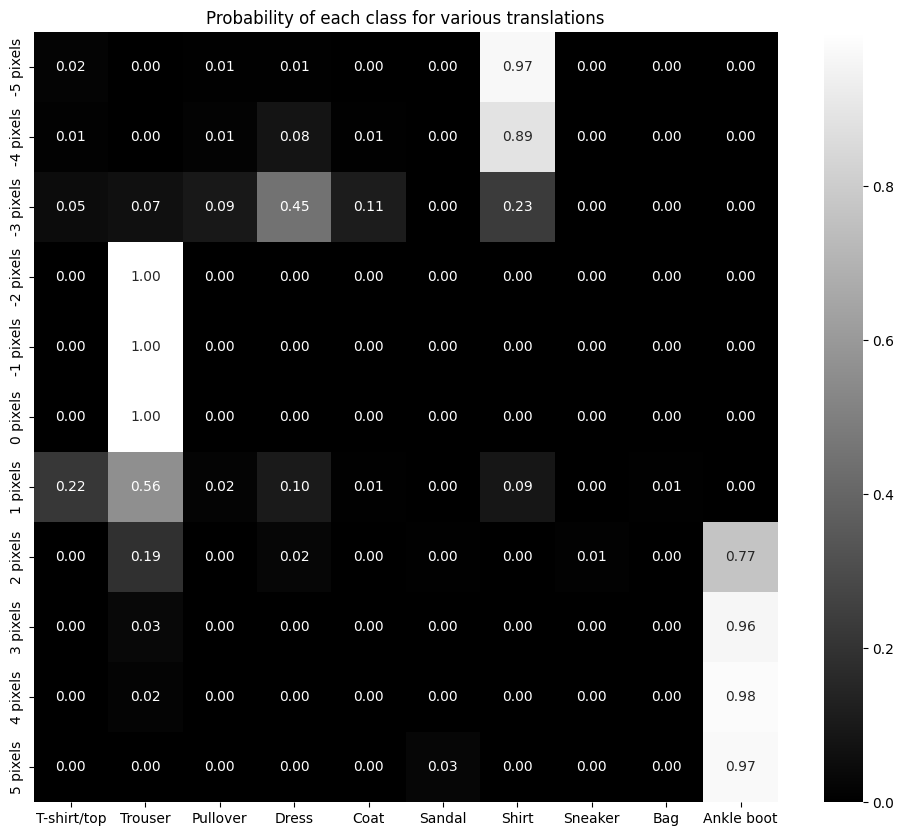

In [16]:
# 4. Visualize the predictions of the model for all the translations (-5 pixels to +5 pixels)
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.show()

* There was no change in the image's content since we only translated the images from 5 pixels to the left and 5 pixels to the right. However, the predicted class of the image changed when the translation was beyond 2 pixels. This is because while the model was being trained, the content in all the training and testing images was at the center. This differs from the preceding scenario where we tested with translated images that are off-center, resulting in an incorrectly predicted class.

    CNNs help address this problem  

---

# Building blocks of a CNN